In [1]:
import geopandas as gpd

In [2]:
#Loading the geometry of each cadastral municipality along with its attributes
kg_ooe = gpd.read_file("data/raw/kg/KATASTRALGEMEINDEN_GEN.shp")
kg_ooe = kg_ooe[kg_ooe.is_valid]
kg_ooe.head()

,KG_NR,KG_NAME,KG_QUELLE,KG_GEMREF,GB_KZ,geometry
0,42016,Obertraun,04/2025,40712,420,"POLYGON ((30309.32 270997.13, 31864.18 268304...."
1,42007,Hallstatt,04/2025,40709,420,"POLYGON ((25237.471 272248.948, 25096.575 2701..."
2,42005,Gosau,04/2025,40706,420,"POLYGON ((15665.503 276816.154, 18558.89 27441..."
3,42015,Obersee,04/2025,40702,420,"POLYGON ((27233.66 271232.27, 25827.25 269839...."
4,42022,Untersee,04/2025,40702,420,"POLYGON ((23856.137 276335.474, 23503.93 27439..."


In [3]:
kg_ooe.crs

<Projected CRS: EPSG:31255>
Name: MGI / Austria GK Central
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Austria between 11°50'E and 14°50'E of Greenwich (29°30'E and 32°30'E of Ferro).
- bounds: (11.83, 46.4, 14.84, 48.79)
Coordinate Operation:
- name: Austria Gauss-Kruger Central
- method: Transverse Mercator
Datum: Militar-Geographische Institut
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [14]:
#Ensuring a unified projection
kg_ooe = kg_ooe.to_crs(epsg=4326)

In [5]:
#Loading the building data for Austria
buildings = gpd.read_file("data/raw/buildings/gis_osm_buildings_a_free_1.shp")
buildings = buildings[buildings.is_valid]
kg_ooe.head()

,KG_NR,KG_NAME,KG_QUELLE,KG_GEMREF,GB_KZ,geometry
0,42016,Obertraun,04/2025,40712,420,"POLYGON ((13.73546 47.57702, 13.75593 47.55273..."
1,42007,Hallstatt,04/2025,40709,420,"POLYGON ((13.66812 47.5885, 13.66613 47.56996,..."
2,42005,Gosau,04/2025,40706,420,"POLYGON ((13.54102 47.62987, 13.57942 47.60817..."
3,42015,Obersee,04/2025,40702,420,"POLYGON ((13.6946 47.57927, 13.67582 47.5668, ..."
4,42022,Untersee,04/2025,40702,420,"POLYGON ((13.64998 47.6253, 13.64519 47.60791,..."


In [6]:
buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
#Spatial join: each building (in Upper Austria) is assigned to a cadastral municipality in Upper Austria
buildings_with_kg = gpd.sjoin(
    buildings,
    kg_ooe,
    how="left",
    predicate="within")
buildings_with_kg.sample()

,osm_id,code,fclass,name,type,geometry,index_right,KG_NR,KG_NAME,KG_QUELLE,KG_GEMREF,GB_KZ
2868242,450084849,1500,building,None,None,"POLYGON ((15.73214 47.60337, 15.73222 47.60344...",NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Creating a dataframe containing only matched buildings (dataframe of buildings of Upper Austria only)
buildings_with_kg_clean=buildings_with_kg[~buildings_with_kg["KG_NR"].isna()]
buildings_with_kg_clean.head()

,osm_id,code,fclass,name,type,geometry,index_right,KG_NR,KG_NAME,KG_QUELLE,KG_GEMREF,GB_KZ
0,4443260,1500,building,Bundesgymnasium Vöcklabruck,None,"POLYGON ((13.66793 48.00729, 13.66812 48.00748...",253.0,50326,Wagrain,04/2025,41746.0,503
19,8043915,1500,building,Kraftwerk Abwinden-Asten,service,"POLYGON ((14.42546 48.25243, 14.42547 48.25246...",773.0,43105,Luftenberg,04/2025,41110.0,432
47,9679087,1500,building,None,university,"POLYGON ((14.317 48.33696, 14.31704 48.33723, ...",923.0,45214,Katzbach,04/2025,40101.0,456
48,9679088,1500,building,None,university,"POLYGON ((14.31744 48.3365, 14.31748 48.33652,...",923.0,45214,Katzbach,04/2025,40101.0,456
49,9679089,1500,building,None,university,"POLYGON ((14.31867 48.33799, 14.31869 48.3381,...",923.0,45214,Katzbach,04/2025,40101.0,456


In [9]:
#Grouping: number of buildings in each cadastral municipality
kg_building_counts = (
    buildings_with_kg
    .groupby("KG_NAME")
    .size()
    .reset_index(name="ANZAHL"))
kg_building_counts.head()

,KG_NAME,ANZAHL
0,Abtsdorf,569
1,Ach,575
2,Achenlohe,667
3,Achleiten,224
4,Ackersberg,272


In [10]:
#The building count is merged back into the cadastral municipality dataset
#Each cadastral municipality now has an additional column containing the building count
kg2 = kg_ooe.merge(
    kg_building_counts,
    on="KG_NAME",
    how="left")
kg2.sample()

,KG_NR,KG_NAME,KG_QUELLE,KG_GEMREF,GB_KZ,geometry,ANZAHL
384,40311,Haimhausen,04/2025,40406,401,"POLYGON ((12.99492 48.11321, 12.99954 48.1096,...",212


<Axes: >

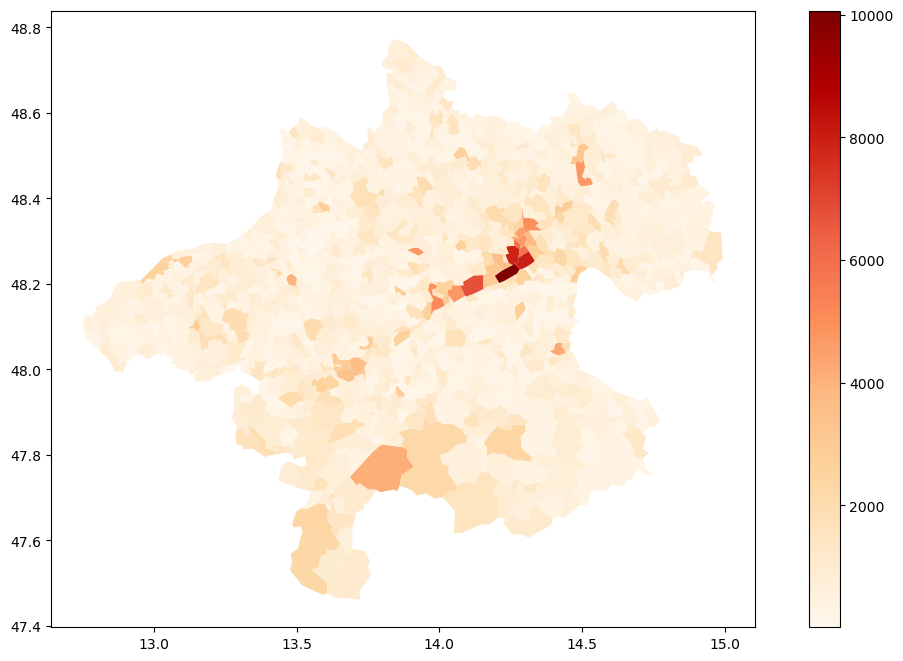

In [11]:
#Plotting the cadastral municipalities including the “building density”
kg2.plot(
    column="ANZAHL",
    cmap="OrRd",
    legend=True,
    figsize=(14, 8))

In [12]:
#Cadastral municipalities with the highest number of buildings
kg_building_counts.sort_values("ANZAHL",ascending=False).head(5)

,KG_NAME,ANZAHL
984,Traun,10054
417,Kleinmünchen,7960
482,Leonding,7875
524,Marchtrenk,6773
1052,Waldegg,5895


In [13]:
#Exporting as a GeoPackage (.gpkg)
kg2.to_file(
    "data/output/kg_building_density.gpkg",
    layer="building_density",
    driver="GPKG")